**Name:** Xian Jia Le,Ben

**EID:** 56214537

# CS5489 - Tutorial 10
## Using Deep Features

In this tutorial you will train a classifier to classify images with different types of cakes using deep features.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
import skimage.io
import skimage.transform

Second, initialize Keras and Tensorflow

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Conv1D,Flatten, Dropout, Input, BatchNormalization, \
                                    GlobalAveragePooling2D, Concatenate,MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import logging
logging.basicConfig()
import struct
import sys
#print("Python:", sys.version, "Keras:", keras.__version__, "TF:", tf.__version__)
print("Python:", sys.version, "TF:", tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')

Python: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)] TF: 2.10.0


## Loading Data and Pre-processing
Next we need to load the images.  Download `cakes.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [3]:
imgdata = []
classes = []

# load the zip file
filename = 'cakes.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "cakes/*/*.jpg"):
        
        # filename is : cakes/class/file.jpg
        (fdir1, fname)  = os.path.split(name)  # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class 

        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        #img = matplotlib.image.imread(myfile)
        img = skimage.io.imread(myfile)
        img2 = skimage.transform.resize(img, (224,224), anti_aliasing=False)
        
        myfile.close()

        imgdata.append(img2)
        classes.append(fclass)
        
zfile.close()
print(len(imgdata))
print(img.size)

c:\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


800
589824


Each image is a 224x224. There are 8 classes of differerent cakes.  Run the below code to show examples of each class.

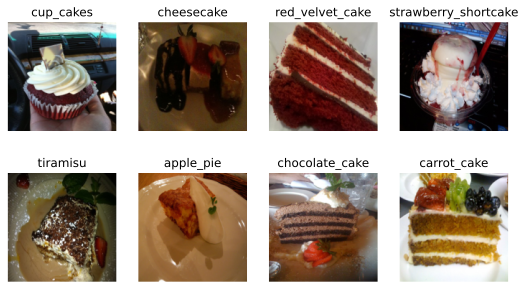

In [4]:
plt.figure(figsize=(9,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    ind = i*100
    plt.imshow(imgdata[ind])    
    plt.title(classes[ind])
    plt.axis('off')
plt.show()

Next, store the images into a Tensor. ResNet assumes the data is [0,255] range, so we need to scale the images that were read in with skimage.

In [5]:
Xraw = zeros((len(imgdata), 224, 224, 3))
for i,img in enumerate(imgdata):
    x = image.img_to_array(img)*255   # preprocessing expects range [0,255]
    x = expand_dims(x, axis=0)
    Xraw[i,:] = x

Finally, we convert the class label strings into class numbers.

In [6]:
# convert class strings into integers
print("class labels (strings):", unique(classes))
le = preprocessing.LabelEncoder()
Y = le.fit_transform(classes)
print("Converted labels:")
print(Y)
Yb = keras.utils.to_categorical(Y)

class labels (strings): ['apple_pie' 'carrot_cake' 'cheesecake' 'chocolate_cake' 'cup_cakes'
 'red_velvet_cake' 'strawberry_shortcake' 'tiramisu']
Converted labels:
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7
 7 7 7 7 7

## Extract Deep features
Now preprocess the images in imdata and put them into a 4D tensor for ResNet.  Store it in a tensor `Xim`.  
Note that `preprocess_input` will overwrite its input data, so you may need to make a `copy` if you want to preserve `Xraw`.

In [ ]:
### INSERT YOUR CODE HERE ###

In [7]:

Xim=keras.applications.resnet50.preprocess_input(Xraw.copy())

Extract features from Resnet50, call it `Xf`.

In [ ]:
### INSERT YOUR CODE HERE ###

In [10]:
model= keras.applications.resnet50.ResNet50(weights="imagenet",include_top=False,pooling="avg")
Xf=model.predict(Xim)
print(f"feature shape :{Xf.shape}")

25/25 [==============================] - 41s 2s/step
feature shape :(800, 2048)


##  Train a classifier
Split the data into training and testing for the classifier.

In [11]:
# randomly split data into train and test set
( trainXf, testXf,       # features 
  trainY, testY,         # class labels
  trainYb, testYb,       # class one-hot vectors
  trainXim, testXim,     # processed images
  trainimgdata, testimgdata,     # raw images
) = \
  model_selection.train_test_split(Xf, Y, Yb, Xim, imgdata,
  train_size=0.8, test_size=0.2, random_state=4487)

print(trainXf.shape)
print(testXf.shape)

# cleanup memory
del trainimgdata, Xraw

(640, 2048)
(160, 2048)


Now train a few traditional classifier (e.g, SVM, logistic regression, random forest, etc.) and compute the accuracy.

In [ ]:
### INSERT YOUR CODE HERE ###

In [12]:
paramgrid={"C":logspace(-3,3,13)}
svmcv = model_selection.GridSearchCV(svm.SVC(kernel="linear"),paramgrid,cv=5,n_jobs=-1,verbose=True)
svmcv.fit(trainXf,trainY)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=5, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])},
             verbose=True)

In [14]:
mypred = svmcv.predict(testXf)
print(f"accuracy = {metrics.accuracy_score(testY,mypred)}")

accuracy = 0.6625


## Analyze results

Run the below code to visualize the predictions on the test set.  `mypred` are the class predictions from your classifier.

In [15]:
# get the class labels
predYcl = le.inverse_transform(mypred)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(10,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")" 
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off()

Now look at the confusion matrix

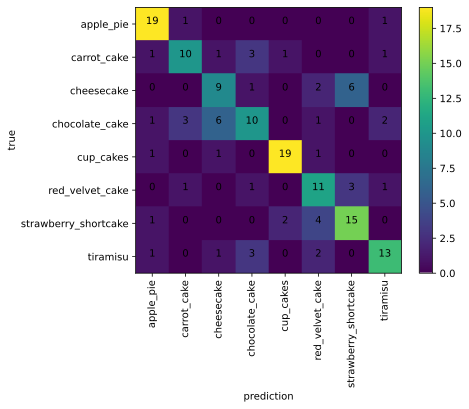

In [16]:
CM = metrics.confusion_matrix(testY, mypred)

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')

_How does the classifier make errors?_

Based on the above confunsion matrix, the classifier will easily predict chocolate_cake to cheesecake and chessecake to strawberry_shortcake

# Transfer learning

Try using a pre-trained network as the backbone for a new network. You can try some of the following:
- training an MLP classifier using the 2048 features from ResNet.
- using other networks (e.g., InceptionNet) to extract the features.
  - remember to change the pre-processing step too.
- using the a feature map (7x7x2048) and applying a small CNN.
- fine-tuning the whole network.

In [ ]:
### INSERT YOUR CODE HERE ####

In [28]:
# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)
testYb  = keras.utils.to_categorical(testY)

In [29]:
# randomly split data into train and test set
( trainXf2, validXf,       # features 
  trainY2, validY,         # class labels
  trainYb2, validYb,       # class one-hot vectors
  trainXim2, validXim,     # processed images
) = \
  model_selection.train_test_split(trainXf, trainYb, trainYb, trainXim,
  train_size=0.9, test_size=0.1, random_state=4487)

print(trainXf2.shape)
print(trainY2.shape)

(576, 2048)
(576, 8)


In [61]:
# res net + mlp

cnn = Sequential()
# cnn.add(Conv2D(32, kernel_size =(5, 5),strides=(2,2),activation ='relu',padding="same"))
# cnn.add(MaxPooling2D(pool_size=(2,2)))
# cnn.add(Conv2D(10, kernel_size =(5, 5),strides=(2,2),activation ='relu',padding="same"))
cnn.add(Dense(units=700,activation="relu"))
cnn.add(Dense(units=70,activation="relu"))
cnn.add(Dense(units=8,activation="softmax"))

cnn.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy']  # also calculate accuracy during training
             )

validsetI = (validXf, validY)
# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_accuracy',             # use validation accuracy for stopping
               min_delta=0.05, patience=7, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

history = cnn.fit(trainXf2,trainY2, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI,  # specify the validation set
                 verbose=True)

Epoch 1/100
12/12 [==============================] - 1s 26ms/step - loss: 2.3501 - accuracy: 0.2795 - val_loss: 1.7012 - val_accuracy: 0.2969
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 1.1666 - accuracy: 0.5851 - val_loss: 1.3200 - val_accuracy: 0.4844
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.7828 - accuracy: 0.7448 - val_loss: 1.2132 - val_accuracy: 0.5938
Epoch 4/100
12/12 [==============================] - 0s 8ms/step - loss: 0.4897 - accuracy: 0.8576 - val_loss: 1.3489 - val_accuracy: 0.5781
Epoch 5/100
12/12 [==============================] - 0s 8ms/step - loss: 0.3417 - accuracy: 0.8924 - val_loss: 1.4687 - val_accuracy: 0.5625
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 0.2237 - accuracy: 0.9549 - val_loss: 1.3586 - val_accuracy: 0.6250
Epoch 7/100
12/12 [==============================] - 0s 8ms/step - loss: 0.1445 - accuracy: 0.9844 - val_loss: 1.4021 - val_accuracy: 0.5938
Epoch 8/100

In [62]:
predY = cnn.predict(testXf)
print(predY[0:3])
mypredY=argmax(predY,axis=1)
print(mypredY[:3])
print(f"accuracy = {metrics.accuracy_score(testY,mypredY)}")

5/5 [==============================] - 0s 0s/step
[[2.2219534e-03 3.7875492e-03 1.6068079e-04 9.7752446e-01 1.4333093e-06
  3.1628748e-03 5.7624846e-05 1.3083429e-02]
 [7.0195262e-07 2.2844544e-04 2.3592906e-02 1.9133393e-05 6.5272220e-04
  1.5558492e-03 9.7366649e-01 2.8372178e-04]
 [3.2095864e-02 5.9339780e-02 2.2188404e-04 7.7882689e-01 7.3057330e-05
  8.1105012e-04 1.5342870e-05 1.2861611e-01]]
[3 6 3]
accuracy = 0.69375


## Analysis
For your best deep learning model, visualize the result and analyze the errors.

In [ ]:
### INSERT YOUR CODE HERE ###

In [63]:
# get the class labels
predYcl = le.inverse_transform(mypredY)
testYcl = le.inverse_transform(testY)

plt.figure(figsize=(10,50))
px = 8
py = int(ceil(len(predYcl)/5))
for i in range(len(predYcl)):
    plt.subplot(py,px,i+1)
    mytitle = predYcl[i] + "\n(" + testYcl[i] + ")" 
    plt.imshow(testimgdata[i], interpolation='nearest')
    plt.title(mytitle, size=8)
    plt.gca().set_axis_off()

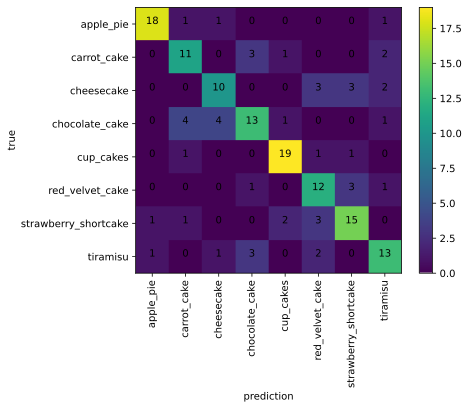

In [64]:
CM = metrics.confusion_matrix(testY, mypredY)

plt.imshow(CM, interpolation='nearest')
plt.colorbar()

tick_marks = arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('prediction')
plt.ylabel('true')
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j,i,"{}".format(CM[i,j]), horizontalalignment='center')

_Where you able to improve the accuracy using deep learning? Analyze the errors from your best model._

The number of missclassify between chocolate_cake between cheese_cake has been reduced. Similarily, the number of missclassify between cheese_cake between strawberry_shortcake also decreases.